In [ ]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

# Task 1. Algorithm's analysis

In [ ]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby
import time

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

### Generating graph

In [ ]:

# You can use this function to generate a random graph with 'num_of_nodes'
# nodes and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

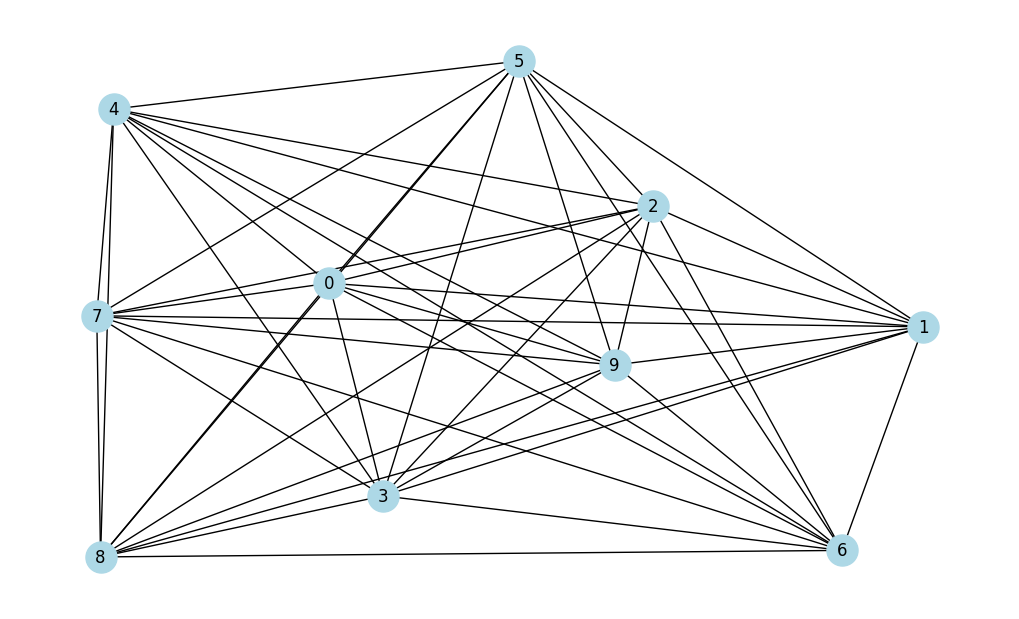

In [ ]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1 (1 point)

### Kruskal's algorithm

#### nx implementation

In [ ]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

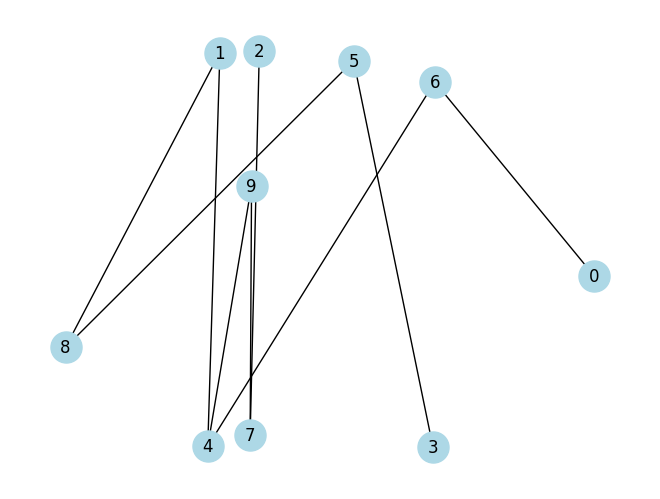

In [ ]:
nx.draw(mstk, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [ ]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 6), (1, 4), (1, 8), (2, 7), (3, 5), (4, 6), (4, 9), (5, 8), (7, 9)]),
 9)

#### Your implementation

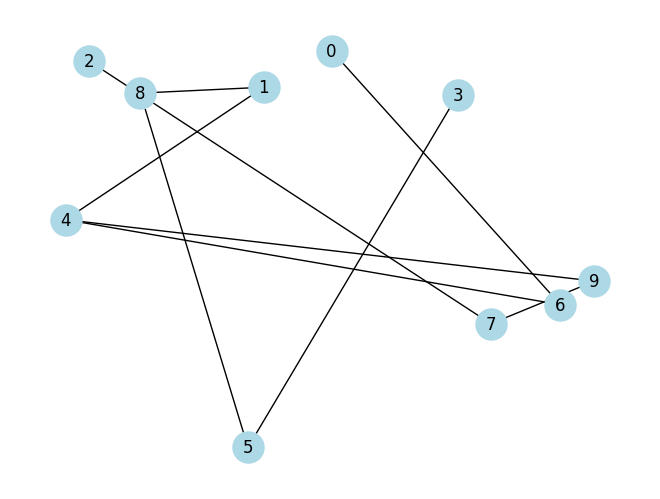

In [ ]:
class KruskalAlgorithm:
  def __init__(self, graph):
    self.parent = list(graph.nodes)
    self.graph = graph

  def find(self, i):
    if self.parent[i] != i:
      return self.find(self.parent[i])

    return i

  def unite(self, i, j):
    ipar = self.find(i)
    jpar = self.find(j)

    if ipar != jpar:
      self.parent[ipar] = jpar
      return True
    return False

  def sort_weights(self):
    self.graph_sorted = []

    for u, v, weight in self.graph.edges(data=True):
        self.graph_sorted.append((u, v, self.graph[u][v]['weight']))
    return sorted(self.graph_sorted, key = lambda node: node[2])

  def create_tree(self):

    self.graph = self.sort_weights()
    tree_edges = []
    new_graph = nx.Graph()
    n = 0

    for edge in self.graph:
      if n == len(self.parent) - 1:
        break
      i = edge[0]
      j = edge[1]
      w = edge[2]
      if self.unite(i, j):
        n += 1
        tree_edges.append((i, j, w))

    new_graph.add_weighted_edges_from(tree_edges)

    return new_graph

a = KruskalAlgorithm(mstk)
my_tree = a.create_tree()
nx.draw(my_tree, node_color='lightblue',
        with_labels=True,
        node_size=500)


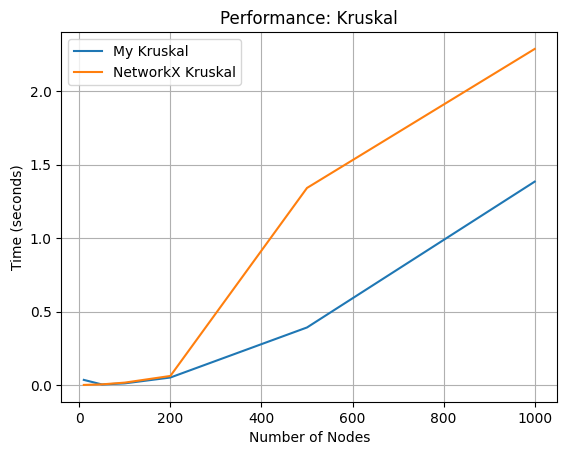

In [ ]:
#COMPARISON
graph_lengths = (10, 50, 100, 200, 500, 1000)
graphs = [gnp_random_connected_graph(n, 50) for n in graph_lengths]
my_times, networkX_times = [], []
for graph in graphs:
  start_time = time.perf_counter()
  my_algorithm = KruskalAlgorithm(graph)
  my_algorithm.create_tree()
  end_time = time.perf_counter()
  my_times.append(end_time - start_time)

  start_time = time.perf_counter()
  mstk = tree.minimum_spanning_tree(graph, algorithm="kruskal")
  end_time = time.perf_counter()
  networkX_times.append(end_time - start_time)

plt.plot(graph_lengths, my_times, label='My Kruskal')
plt.plot(graph_lengths, networkX_times, label='NetworkX Kruskal')
plt.title('Performance: Kruskal')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


*Ми застосували DSU і тому наш алгоритм вийшов оптимізованіший ніж networkX.*

#### Additional point (+0.5)

Use DSU (disjoint set union) in implementation of the algorithm

### Prim's algorithm

#### nx implementation

In [ ]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

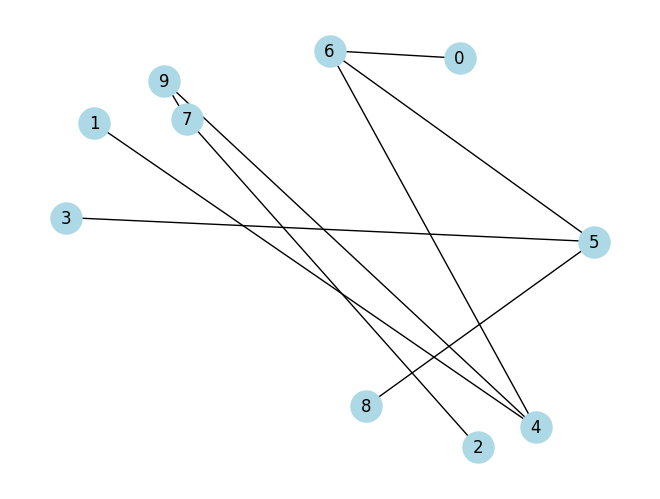

In [ ]:
nx.draw(mstp, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [ ]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 6), (1, 4), (2, 7), (3, 5), (4, 6), (4, 9), (5, 6), (5, 8), (7, 9)]),
 9)

#### Your implementation

In [ ]:
class Prim_algorithm:

  def __inti__(self, graph):
    self.graph = graph



![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Subtask 1.2 (1 point)

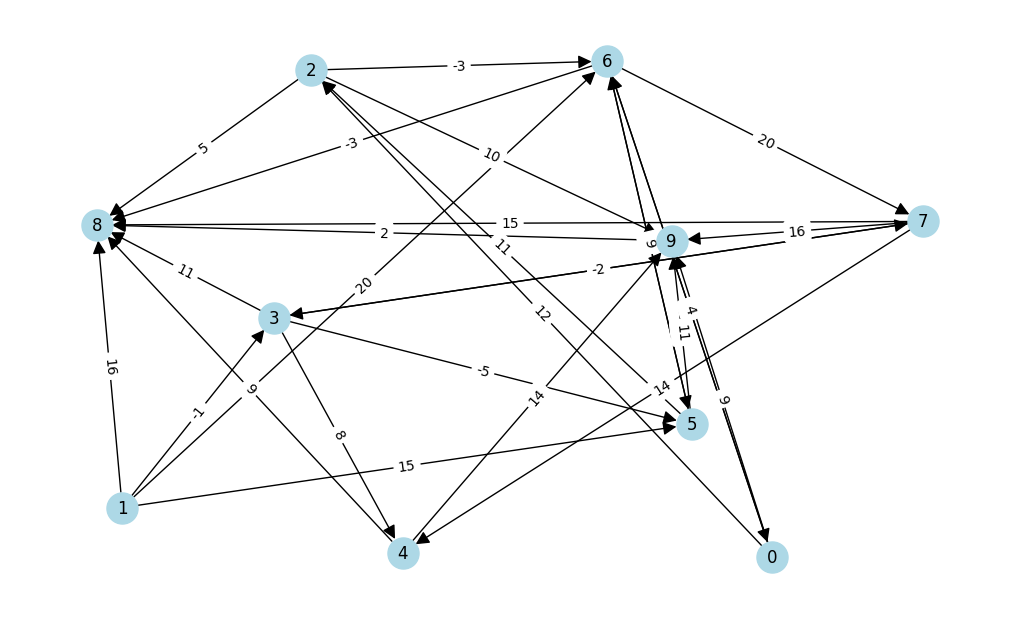

In [ ]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

#### nx implementation

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Negative cycle detected


#### Your implementation

In [ ]:
def bellman_ford_custom(G, source):

    dist = {node: float('inf') for node in G.nodes()}
    pred = {node: None for node in G.nodes()}
    dist[source] = 0

    vertices = list(G.nodes())

    edges = []
    for u, v, data in G.edges(data=True):
        edges.append((u, v, data['weight']))

    for _ in range(len(vertices) - 1):
        changed = False
        for u, v, w in edges:
            if dist[u] != float('inf') and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u
                changed = True

        if not changed:
            break

    for u, v, w in edges:
        if dist[u] != float('inf') and dist[u] + w < dist[v]:
            raise ValueError("Negative cycle detected")

    return pred, dist

try:
    my_pred, my_dist = bellman_ford_custom(G, 0)

    for k, v in my_dist.items():
        print(f"Distance to {k}:", v)

except:
    print("Negative cycle detected")

Negative cycle detected


### Floyd-Warshall algorithm

#### nx implementation

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 2: 12, 6: -4, 9: 9, 1: inf, 3: 14, 4: 22, 5: 5, 7: 9, 8: -7}
Distances with 1 source: {1: 0, 3: -8, 5: -13, 6: -15, 8: -25, 0: -11, 2: -2, 4: 0, 7: -13, 9: -9}
Distances with 2 source: {2: 0, 6: -3, 8: -6, 9: 10, 0: 1, 1: inf, 3: 15, 4: 23, 5: 6, 7: 10}
Distances with 3 source: {3: -7, 4: 1, 5: -12, 7: -12, 8: -24, 0: -10, 1: inf, 2: -1, 6: -14, 9: -8}
Distances with 4 source: {4: 0, 8: 9, 9: 14, 0: inf, 1: inf, 2: inf, 3: inf, 5: inf, 6: inf, 7: inf}
Distances with 5 source: {5: 0, 2: 11, 6: -2, 9: 11, 0: 2, 1: inf, 3: 16, 4: 24, 7: 11, 8: -5}
Distances with 6 source: {6: 0, 0: 4, 5: 9, 7: 13, 8: -3, 1: inf, 2: 16, 3: 18, 4: 26, 9: 13}
Distances with 7 source: {7: -14, 3: -9, 4: -1, 9: -10, 8: -26, 0: -12, 1: inf, 2: -3, 5: -14, 6: -16}
Distances with 8 source: {8: 0, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf}
Distances with 9 source: {9: 0, 8: 2, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf}


#### Your implementation

In [ ]:
def floyd_warshall_custom(G):
    nodes = list(G.nodes())

    dist = {i: {j: float('inf') for j in nodes} for i in nodes}
    pred = {i: {j: None for j in nodes} for i in nodes}

    for i in nodes:
        dist[i][i] = 0

    for u, v, data in G.edges(data=True):
        weight = data['weight']

        if weight < dist[u][v]:
            dist[u][v] = weight
            pred[u][v] = u

    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dist[i][k] != float('inf') and dist[k][j] != float('inf'):
                    if dist[i][k] + dist[k][j] < dist[i][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]
                        pred[i][j] = pred[k][j]

    for i in nodes:
        if dist[i][i] < 0:
            raise ValueError("Negative cycle detected")

    return pred, dist

try:
    my_pred, my_dist = floyd_warshall_custom(G)

    for k, v in my_dist.items():
        print(f"Distances with {k} source:", v)

except:
    print("Negative cycle detected")

Negative cycle detected


Bellman-Ford test


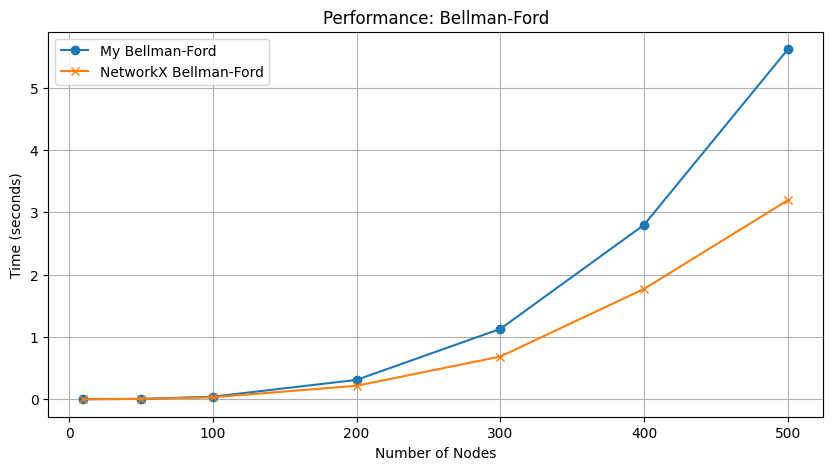

Floyd-Warshall test


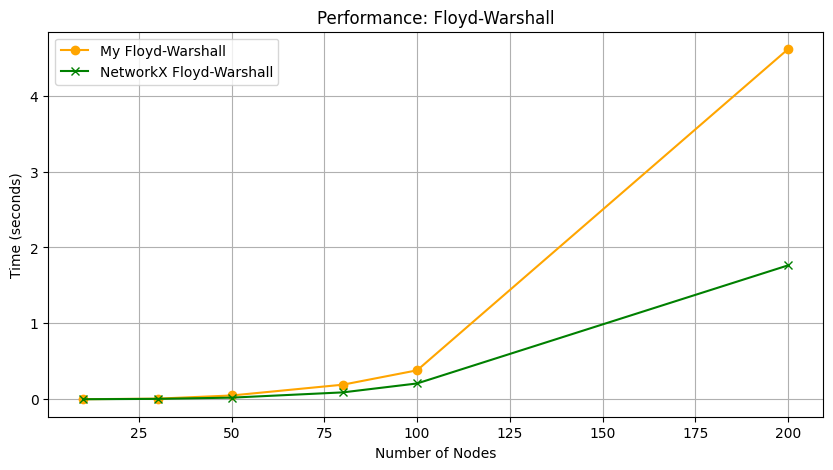

In [ ]:
#TESTING


print("Bellman-Ford test")

bf_sizes = [10, 50, 100, 200, 300, 400, 500]
my_times_bf = []
nx_times_bf = []

for n in bf_sizes:

    G = gnp_random_connected_graph(n, 0.3, directed=True)

    # Вимір мого алгоритму
    runs = []
    for _ in range(3):
        start = time.time()
        try:
            bellman_ford_custom(G, 0)
        except ValueError:
            pass
        runs.append(time.time() - start)
    my_times_bf.append(min(runs))

    # Вимір NetworkX
    runs = []
    for _ in range(3):
        start = time.time()
        try:
            nx.bellman_ford_predecessor_and_distance(G, 0)
        except nx.NetworkXUnbounded:
            pass
        runs.append(time.time() - start)
    nx_times_bf.append(min(runs))

plt.figure(figsize=(10, 5))
plt.plot(bf_sizes, my_times_bf, marker='o', label='My Bellman-Ford')
plt.plot(bf_sizes, nx_times_bf, marker='x', label='NetworkX Bellman-Ford')
plt.title('Performance: Bellman-Ford')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


print("Floyd-Warshall test")

fw_sizes = [10, 30, 50, 80, 100,200]
my_times_fw = []
nx_times_fw = []

for n in fw_sizes:
    G = gnp_random_connected_graph(n, 0.5, directed=True)

    #Мій алгоритм
    start = time.time()
    try:
        floyd_warshall_custom(G)
    except ValueError:
        pass
    my_times_fw.append(time.time() - start)

    #NetworkX
    start = time.time()
    try:
        nx.floyd_warshall_predecessor_and_distance(G)
    except nx.NetworkXUnbounded:
        pass
    nx_times_fw.append(time.time() - start)

plt.figure(figsize=(10, 5))
plt.plot(fw_sizes, my_times_fw, marker='o', color='orange', label='My Floyd-Warshall')
plt.plot(fw_sizes, nx_times_fw, marker='x', color='green', label='NetworkX Floyd-Warshall')
plt.title('Performance: Floyd-Warshall')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

Висновок:
Експеримент показав, що власна реалізація алгоритму Беллмана-Форда та Флойда-Воршала працює майже так само ефективно, як і бібліотечна функція NetworkX. Різниця в часі незначна  і обумовлена лише внутрішніми оптимізаціями бібліотеки, а не алгоритмічною складністю. Обидві реалізації демонструють однакову залежність часу від розміру графа

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Useful explanations

### How to get list of edges for your algorithm

In [ ]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [ ]:
edges[:5]

[(0, 3), (0, 8), (0, 11), (0, 12), (0, 13)]

### To get edges with weights

In [ ]:
edges = list(G.edges(data=True))

In [ ]:
edges[:5]

[(0, 3, {'weight': 11}),
 (0, 8, {'weight': 13}),
 (0, 11, {'weight': 17}),
 (0, 12, {'weight': 6}),
 (0, 13, {'weight': -1})]

In [ ]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


### Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [ ]:
import time
from tqdm import tqdm

In [ ]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):

    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)

    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()

    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:09<00:00, 103.62it/s]


0.0024451968669891356

# Task 2. Decision Tree Classifier

In [ ]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## General idea


You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://medium.com/data-science/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575

Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Dataset

You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set

However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.

P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

In [ ]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [ ]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [ ]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

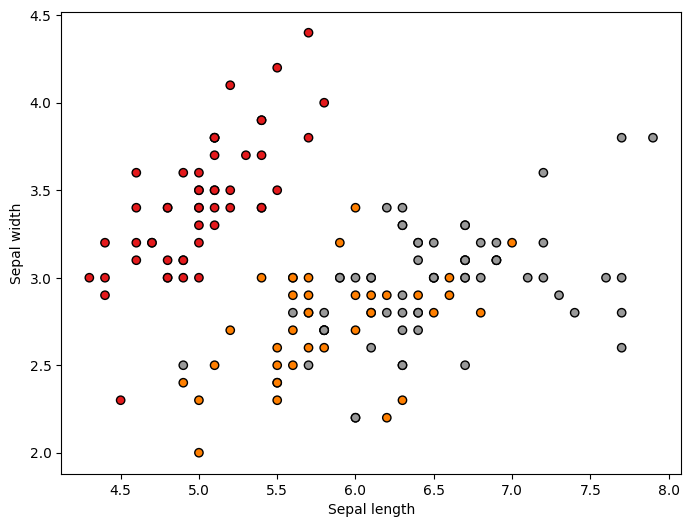

In [ ]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage

**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [ ]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [ ]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

'iris.pdf'

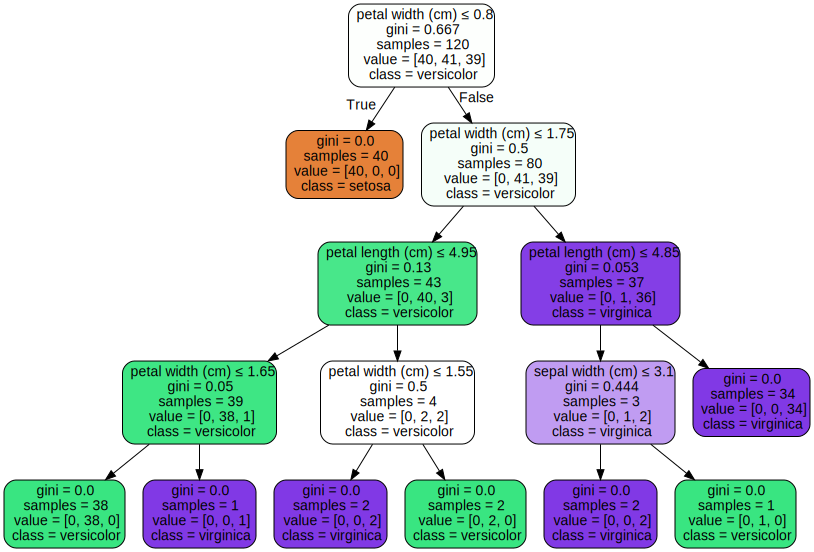

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [ ]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [ ]:
sum(predictions == y_test) / len(y_test)

np.float64(0.9666666666666667)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [ ]:
y_test

array([0, 0, 2, 0, 1, 2, 1, 0, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 2, 0, 1,
       1, 0, 2, 2, 0, 1, 2, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [ ]:
X_test[1]

array([4.6, 3.2, 1.4, 0.2])

In [ ]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Decision tree classifier (2 point)

###  Gini impurity


Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$


### Remarks


:- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.

In [ ]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray, predicted_class = None):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
        self.predicted_class = predicted_class

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int = None, alpha: float = 1.0) -> None:
        self.max_depth = max_depth
        self.alpha = alpha
        self.tree = None
        self.number_of_classes = None

    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = len(np.unique(y))
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X : npt.NDArray, y: npt.NDArray, depth = 0):
        num_samples, num_features = X.shape
        unique_classes = len(np.unique(y))

        if self.max_depth is None:
            self.max_depth = num_features

        if unique_classes == 1 or depth >= self.max_depth or num_samples < 2:
            return Node(X, y, predicted_class=self._most_common_label(y))

        best_idx, best_thr = self._best_split(X, y, num_features)

        if best_idx is None:
             return Node(X, y, predicted_class=self._most_common_label(y))

        left_idxs, right_idxs = self._split(X[:, best_idx], best_thr)

        left = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        node = Node(X, y)
        node.feature_index = best_idx
        node.threshold = best_thr
        node.left = left
        node.right = right
        return node

    def _best_split(self, X, y, num_features):
        best_gain = 0
        split_idx, split_threshold = None, None

        for feature_index in range(num_features):
            X_column = X[:, feature_index]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_index
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._calculate_entropy(y)

        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)

        entropy_left, entropy_right = self._calculate_entropy(y[left_idxs]), self._calculate_entropy(y[right_idxs])
        child_entropy = (len(left_idxs) / n) * entropy_left + (len(right_idxs) / n) * entropy_right

        return parent_entropy - child_entropy

    def _split(self, X_column, split_threshold):
        left_idxs = np.flatnonzero(X_column <= split_threshold)
        right_idxs = np.flatnonzero(X_column > split_threshold)

        return left_idxs, right_idxs

    def _calculate_entropy(self, y):
        n = len(y)
        if n == 0:
            return 0

        K = self.number_of_classes

        unique_vals, counts = np.unique(y, return_counts=True)

        ps_present = (counts + self.alpha) / (n + self.alpha * K)

        n_missing = K - len(unique_vals)
        p_missing = self.alpha / (n + self.alpha * K)

        entropy = -np.sum(ps_present * np.log2(ps_present))

        if n_missing > 0 and p_missing > 0:
            entropy -= n_missing * (p_missing * np.log2(p_missing))

        return entropy

    def _most_common_label(self, y):

        unique, counts = np.unique(y, return_counts=True)
        return unique[np.argmax(counts)]

    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it
        """
        return np.array([self._traverse_tree(x, self.tree) for x in X_test])

    def _traverse_tree(self, x, node):
        if node.predicted_class is not None:
             return node.predicted_class


        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



In [ ]:

def evaluate(X_test: list[list], y_test: list, tree: DecisionTreeClassifier) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    result = tree.predict(X_test)
    accuracy = np.sum(result == y_test) / len(y_test)
    return f"Accuracy of the tree is {(float(accuracy) * 100):.2f}%"

### Your implementation

In [ ]:
split_size = 0.9
train_data, test_data = np.split(iris.data, [int(split_size * len(iris.data))])
train_target, test_target = np.split(iris.target, [int(split_size * len(iris.data))])
mytree = DecisionTreeClassifier()
mytree.fit(train_data, train_target)
evaluate(test_data, test_target, mytree)

'Accuracy of the tree is 93.33%'

#### Additional point (+0.5)

Use Laplace smoothing, explain what is the point of using it

У даному класі ми використали згладжування Лапласа. Воно додає невеличке значення у знаменнику при пошуку ентропіїю Це робиться для того, щоб заохочувати дерево розділяти на більш значні групи, що робить його точнішим. Також у рідких випадках може врятувати від помилки ділення на нуль.

# **Висновок**

У результаті виконання лабораторної роботи було перевірено роботу кількох алгоритмів на графах різного розміру. Загальні залежності зберігаються: зі збільшенням кількості вершин і ребер час виконання також зростає. Отримані графіки показують подібну форму до реалізацій з NetworkX, але власна реалізація в деяких випадках працює повільніше, а в деяких(алгоритм Краскала) швидше. Це пов’язано з тим, наскільки оптимізовані ці алгоритми порівняно з власне бібліотекою. Найкраще алгоритми працюють на невеликих і менш щільних графах, а найгірше це на великих графах із великою кількістю ребер. Загалом результати підтверджують правильність реалізації, хоча швидкодія нижча, ніж у бібліотечних алгоритмів.
